In [1]:
import folium
import pandas as pd
from folium.plugins import MarkerCluster
from branca.colormap import linear

# 1. 전처리
충남 전지역 처리해서 지역별로 선택해서 볼 수 있게. 합 지도 만들기

In [2]:
## 목적지 분류 별 방문건수 시각화_공주시 데이터
# 데이터 로드
df = pd.read_csv("./bj_navi_전처리데이터.csv")

df = df.groupby(
    ['대분류', '소분류', '목적지명','목적지읍면동명', '목적지X좌표', '목적지Y좌표'], as_index=False
)['방문건수'].sum()

# 지도 생성 (중심을 대략적인 평균 좌표로 설정)
map_center = [df['목적지Y좌표'].mean(), df['목적지X좌표'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# 붉은 계열 색상 그라데이션 설정 (방문건수에 따른 색상 설정)
colormap = linear.Reds_09.scale(df['방문건수'].min(), df['방문건수'].max())

# 방문건수에 따른 오름차순 정렬 (작은 값이 먼저 그려지도록)
df_sorted = df.sort_values(by='방문건수', ascending=True)

# 방문건수구간별로 마커 그룹 만들기
marker_groups = {}
for group in df_sorted['대분류'].unique():
    show_group = True if group == '여행/레저' else False  # 방문건수구간이 5인 경우, '방문 1순위 지점'으로 기본 표시
    marker_groups[group] = folium.FeatureGroup(name=f"{group}", show=show_group)

# 마커 추가
for _, row in df_sorted.iterrows():
    color = colormap(row['방문건수'])
    
    # CircleMarker 생성
    label = f"{row['목적지읍면동명']}, {row['소분류']}, 방문건수: {row['방문건수']}"
    marker = folium.CircleMarker(
        location=[row['목적지Y좌표'], row['목적지X좌표']],
        radius=7 + row['방문건수'] * 0.000001,  # 방문건수에 따라 크기 조절
        color=color,
        fill=True,
        fill_opacity=0.7,
        tooltip=label,
    )
    
    # 마커 그룹에 추가
    marker.add_to(marker_groups[row['대분류']])

# 마커 그룹을 지도에 추가
for group in marker_groups.values():
    group.add_to(m)

# 레이어 컨트롤 추가 (레이어 선택 가능)
folium.LayerControl().add_to(m)

# 지도 저장
m.save('map_b_전처리_count.html')

# 2. 주요목적지
주요목적지기준으로 전체 방문건수 sum
=> togo_count.csv

In [3]:
## 방문건수 시각화_공주시 데이터
# 데이터 로드
df = pd.read_csv("./b_togo_count.csv")

In [4]:
# 분위수 계산 (20분위수, 40분위수, 60분위수, 80분위수, 100분위수)
quantiles = df['방문건수'].quantile([0.2, 0.4, 0.6, 0.8, 1.0])

# 각 행의 '방문건수'가 어느 분위수에 속하는지 확인하여 '방문건수구간' 컬럼에 저장
def assign_visit_range(visit_count):
    if visit_count <= quantiles[0.2]:
        return 1
    elif visit_count <= quantiles[0.4]:
        return 2
    elif visit_count <= quantiles[0.6]:
        return 3
    elif visit_count <= quantiles[0.8]:
        return 4
    else:
        return 5

df['방문건수구간'] = df['방문건수'].apply(assign_visit_range)

# 결과 출력
df.head()


,목적지명,목적지X좌표,목적지Y좌표,목적지시군구명,목적지읍면동명,대분류,중분류,소분류,방문건수,방문건수구간
0,24시전주명가 콩나물국밥,126.910918,36.277138,부여군,부여읍,생활편의,음식점,한식,170,5
1,60계치킨/충남부여점,126.911001,36.279699,부여군,부여읍,생활편의,음식점,치킨,13,4
2,BHC/부여규암점,126.882976,36.274194,부여군,규암면,생활편의,음식점,치킨,3,1
3,BHC/부여은산점,126.852521,36.308711,부여군,은산면,생활편의,음식점,치킨,3,1
4,BHC/부여홍산점,126.760287,36.215820,부여군,홍산면,생활편의,음식점,치킨,3,1


In [5]:
# 지도 생성 (중심을 대략적인 평균 좌표로 설정)
map_center = [df['목적지Y좌표'].mean(), df['목적지X좌표'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# 붉은 계열 색상 그라데이션 설정 (방문건수에 따른 색상 설정)
colormap = linear.Reds_09.scale(df['방문건수'].min(), df['방문건수'].max())

# 방문건수에 따른 오름차순 정렬 (작은 값이 먼저 그려지도록)
df_sorted = df.sort_values(by='방문건수', ascending=True)

# 방문건수구간별로 마커 그룹 만들기
marker_groups = {}
for group in df_sorted['방문건수구간'].unique():
    show_group = True if group == 5 else False  # 방문건수구간이 5인 경우, '방문 1순위 지점'으로 기본 표시
    an = 6 - group
    marker_groups[group] = folium.FeatureGroup(name=f"방문 {an}순위 지점", show=show_group)

# 마커 추가
for _, row in df_sorted.iterrows():
    color = colormap(row['방문건수'])
    
    # CircleMarker 생성
    label = f"{row['목적지읍면동명']}, {row['소분류']}, 방문건수: {row['방문건수']}"
    marker = folium.CircleMarker(
        location=[row['목적지Y좌표'], row['목적지X좌표']],
        radius=7 + row['방문건수'] * 0.000001,  # 방문건수에 따라 크기 조절
        color=color,
        fill=True,
        fill_opacity=0.7,
        tooltip=label,
    )
    
    # 마커 그룹에 추가
    marker.add_to(marker_groups[row['방문건수구간']])

# 마커 그룹을 지도에 추가
for group in marker_groups.values():
    group.add_to(m)

# 레이어 컨트롤 추가 (레이어 선택 가능)
folium.LayerControl().add_to(m)

# 지도 저장
m.save('map_b_togo_count.html')

출발지역이 공주가 아닌 경우=> not_togo_count.csv

In [6]:
## 방문건수 시각화_공주시데이터_외부유입 방문객
# 데이터 로드
df = pd.read_csv("./b_not_togo_count.csv")

# 분위수 계산 (20분위수, 40분위수, 60분위수, 80분위수, 100분위수)
quantiles = df['방문건수'].quantile([0.2, 0.4, 0.6, 0.8, 1.0])

# 각 행의 '방문건수'가 어느 분위수에 속하는지 확인하여 '방문건수구간' 컬럼에 저장
def assign_visit_range(visit_count):
    if visit_count <= quantiles[0.2]:
        return 1
    elif visit_count <= quantiles[0.4]:
        return 2
    elif visit_count <= quantiles[0.6]:
        return 3
    elif visit_count <= quantiles[0.8]:
        return 4
    else:
        return 5

df['방문건수구간'] = df['방문건수'].apply(assign_visit_range)

# 결과 출력
df.head()

# 지도 생성 (중심을 대략적인 평균 좌표로 설정)
map_center = [df['목적지Y좌표'].mean(), df['목적지X좌표'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# 붉은 계열 색상 그라데이션 설정 (방문건수에 따른 색상 설정)
colormap = linear.Reds_09.scale(df['방문건수'].min(), df['방문건수'].max())

# 방문건수에 따른 오름차순 정렬 (작은 값이 먼저 그려지도록)
df_sorted = df.sort_values(by='방문건수', ascending=True)

# 방문건수구간별로 마커 그룹 만들기
marker_groups = {}
for group in df_sorted['방문건수구간'].unique():
    show_group = True if group == 5 else False  # 방문건수구간이 5인 경우, '방문 1순위 지점'으로 기본 표시
    an = 6 - group
    marker_groups[group] = folium.FeatureGroup(name=f"방문 {an}순위 지점", show=show_group)

# 마커 추가
for _, row in df_sorted.iterrows():
    color = colormap(row['방문건수'])
    
    # CircleMarker 생성
    label = f"{row['목적지읍면동명']}, {row['소분류']}, 방문건수: {row['방문건수']}"
    marker = folium.CircleMarker(
        location=[row['목적지Y좌표'], row['목적지X좌표']],
        radius=7 + row['방문건수'] * 0.000001,  # 방문건수에 따라 크기 조절
        color=color,
        fill=True,
        fill_opacity=0.7,
        tooltip=label,
    )
    
    # 마커 그룹에 추가
    marker.add_to(marker_groups[row['방문건수구간']])

# 마커 그룹을 지도에 추가
for group in marker_groups.values():
    group.add_to(m)

# 레이어 컨트롤 추가 (레이어 선택 가능)
folium.LayerControl().add_to(m)

# 지도 저장
m.save('map_b_not_togo_count.html')

축제기간 여부를 변수로 가지는 => fest_togo_count

In [7]:
## 축제기간 여부 / 방문지 인기도
# 데이터 로드
df = pd.read_csv("./b_fest_togo_count.csv")

# 분위수 계산 (20분위수, 40분위수, 60분위수, 80분위수, 100분위수)
quantiles = df['방문건수'].quantile([0.5])

# 각 행의 '방문건수'가 어느 분위수에 속하는지 확인하여 '방문건수구간' 컬럼에 저장
def assign_visit_range(visit_count):
    if visit_count <= quantiles[0.5]:
        return "보통"
    else:
        return "인기"

df['방문건수구간'] = df['방문건수'].apply(assign_visit_range)

# 결과 출력
df.head()

# festival_period를 문자열로 변환 (숫자일 경우 대비)
df['festival_period'] = df['festival_period'].astype(str)

# 지도 생성 (중심을 대략적인 평균 좌표로 설정)
map_center = [df['목적지Y좌표'].mean(), df['목적지X좌표'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# 붉은 계열 색상 그라데이션 설정 (방문건수에 따른 색상 설정)
colormap = linear.Reds_09.scale(df['방문건수'].min(), df['방문건수'].max())

# 방문건수에 따른 오름차순 정렬 (작은 값이 먼저 그려지도록)
df_sorted = df.sort_values(by='방문건수', ascending=True)

# print(df_sorted)

# 'festival_period'와 '방문건수구간'에 따른 마커 그룹 만들기
marker_groups = {}
for period in df_sorted['festival_period'].unique():
    # 축제 기간에 따라 그룹명 설정
    if period == '0': 
        aan = '축제기간 전'
    elif period == '1': 
        aan = '축제기간 중'
    else: 
        aan = '축제기간 후'
    for group in df_sorted['방문건수구간'].unique():
        show_group = True if (aan == '축제기간 후') & (group == '인기') else False # 기본적으로 모든 그룹 표시
        # 그룹 이름을 'festival_period'와 '방문건수구간'의 조합으로 설정
        marker_groups[(period, group)] = folium.FeatureGroup(name=f"{aan} - 방문 {group} 지점", show=show_group)

# 마커 추가
for _, row in df_sorted.iterrows():
    color = colormap(row['방문건수'])
    
    # CircleMarker 생성
    label = f"{row['목적지읍면동명']}, {row['소분류']}, 방문건수: {row['방문건수']}"
    marker = folium.CircleMarker(
        location=[row['목적지Y좌표'], row['목적지X좌표']],
        radius=7 + row['방문건수'] * 0.000001,  # 방문건수에 따라 크기 조절
        color=color,
        fill=True,
        fill_opacity=0.7,
        fill_color=colormap(row['방문건수']),
        tooltip=label,
    )
    
    # 'festival_period'와 '방문건수구간'에 해당하는 마커 그룹에 추가
    marker.add_to(marker_groups[(row['festival_period'], row['방문건수구간'])])

# 마커 그룹을 지도에 추가
for group in marker_groups.values():
    group.add_to(m)

# 레이어 컨트롤 추가 (레이어 선택 가능)
folium.LayerControl().add_to(m)

# 지도 저장
m.save('map_b_fest_togo_count.html')


출발지역이 공주가 아닌데이터에 대해서 축제기간 여부를 변수로 가지는 => fest_not_togo_count.csv


In [8]:
## 공주 외부유입 데이터_축제기간 내외, 목적지 분류 별
# 데이터 로드
df = pd.read_csv("./b_fest_not_togo_count.csv")

# '목적지명', 'festival_period' 등을 기준으로 방문건수를 그룹화
df = df.groupby(
    ['목적지명', '목적지X좌표', '목적지Y좌표', '목적지시군구명', '목적지읍면동명', '대분류', '중분류', '소분류', 'festival_period'], 
    as_index=False
)['방문건수'].sum()

# 지도 생성 (중심을 대략적인 평균 좌표로 설정)
map_center = [df['목적지Y좌표'].mean(), df['목적지X좌표'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# 붉은 계열 색상 그라데이션 설정 (방문건수에 따른 색상 설정)
colormap = linear.Reds_09.scale(df['방문건수'].min(), df['방문건수'].max())

# 방문건수에 따른 오름차순 정렬 (작은 값이 먼저 그려지도록)
df_sorted = df.sort_values(by='방문건수', ascending=True)

# 'festival_period'와 '대분류'에 따른 마커 그룹 만들기
marker_groups = {}
for period in df_sorted['festival_period'].unique():
    # 축제 기간에 따라 그룹명 설정
    if period == 0:  # 이 부분을 '0'에서 숫자 0으로 변경
        aan = '축제기간 외'
    else: 
        aan = '축제기간 중'
    for group in df_sorted['대분류'].unique():
        show_group = True if (group == '여행/레저') and (aan == '축제기간 중') else False  # 모든 그룹을 기본적으로 표시
        # 그룹 이름을 'festival_period'와 '대분류'의 조합으로 설정
        marker_groups[(period, group)] = folium.FeatureGroup(name=f"{aan} - {group} 방문지", show=show_group)

# 마커 추가
for _, row in df_sorted.iterrows():
    color = colormap(row['방문건수'])
    
    # CircleMarker 생성
    label = f"{row['목적지읍면동명']}, {row['소분류']}, 일 평균 방문건수: {round(row['방문건수'],1)}"
    marker = folium.CircleMarker(
        location=[row['목적지Y좌표'], row['목적지X좌표']],
        radius=7 + row['방문건수'] * 0.001,  # 방문건수에 따라 크기 조절
        color=color,
        fill=True,
        fill_opacity=0.7,
        tooltip=label,
    )
    
    # 'festival_period'와 '대분류'에 해당하는 마커 그룹에 추가
    marker.add_to(marker_groups[(row['festival_period'], row['대분류'])])

# 마커 그룹을 지도에 추가
for group in marker_groups.values():
    group.add_to(m)

# 레이어 컨트롤 추가 (레이어 선택 가능)
folium.LayerControl().add_to(m)

# 지도 저장
m.save('map_b_fest_not_togo_count.html')


# 3. navi_방문지만
축제기간 여부를 변수로 가지는 연계방문지 방문건수 sum => fest_visit_count.csv

In [9]:
# 'festival_period'의 값에 따른 방문건수 합계 구하기
# 축제 전/중/후 값을 각각 따로 계산
df = pd.read_csv("./b_fest_visit_count.csv")

# festival_period 값을 모두 '전체기간'으로 변경


# festival_period를 기준으로 데이터를 합치고, 방문건수는 합계, 나머지는 첫 번째 값으로 처리
df_aggregated = df.groupby(
    ['목적지명_통합', '목적지X좌표', '목적지Y좌표'], as_index=False
).agg({
    '방문건수': 'sum',  # 방문건수는 합계로 처리
    '표시용행정구역': 'first',  # 나머지는 첫 번째 값으로 처리
    'festival_period': 'first',  # 모든 값이 '전체기간'으로 설정됨
    'is_weekend': 'first',
    '요일': 'first',
})

df_aggregated['festival_period'] = '전체기간'

# 결과 확인
print(df_aggregated.head())
df_aggregated.to_csv('df_aggregated.csv', encoding='utf-8-sig', index=False)

# 열 순서를 맞추기 위해, df의 열 순서를 기준으로 df_aggregated 열 순서 맞춤
df_aggregated = df_aggregated[df.columns]

# df와 df_aggregated를 행으로 결합 (즉, 데이터를 이어 붙임)
df_combined = pd.concat([df, df_aggregated], ignore_index=True, axis=0)

# 결과 확인
print(df_combined.head())

# 데이터 저장 (필요시)
df_combined.to_csv('combined_output.csv', encoding='utf-8-sig', index=False)

              목적지명_통합      목적지X좌표     목적지Y좌표  방문건수  표시용행정구역 festival_period  \
0     1914호남선항구포차/3호점  126.388140  34.780829   1.0  nan nan            전체기간   
1        24시더원동물메디컬센터  127.433128  36.357244   1.0  nan nan            전체기간   
2       24시전주명가 콩나물국밥  126.910918  36.277138  19.0  nan nan            전체기간   
3  24시전주명가콩나물국밥/익산모현점  126.941520  35.951836   1.0  nan nan            전체기간   
4            365웰니스의원  127.126479  36.793976   1.0  nan nan            전체기간   

   is_weekend        요일  
0           1  Saturday  
1           1  Saturday  
2           1    Sunday  
3           1    Sunday  
4           0   Tuesday  
  festival_period        목적지명_통합      목적지X좌표     목적지Y좌표  표시용행정구역  방문건수  \
0               0   24시더원동물메디컬센터  127.433128  36.357244  nan nan   1.0   
1               0  24시전주명가 콩나물국밥  126.910918  36.277138  nan nan   5.0   
2               0    60계치킨/충남부여점  126.911001  36.279699  nan nan   2.0   
3               0         AK&/세종  127.258846  36.501130  nan nan   1.0   

In [10]:
## 축제기간 여부에 따른 방문건수 시각화_공주시 데이터
# 데이터 로드
df = pd.read_csv("./combined_output.csv")

# festival_period가 숫자로 저장된 경우 문자열로 변환
df['festival_period'] = df['festival_period'].astype(str)

# 지도 생성 (중심을 대략적인 평균 좌표로 설정)
map_center = [df['목적지Y좌표'].mean(), df['목적지X좌표'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# 붉은 계열 색상 그라데이션 설정 (방문건수에 따른 색상 설정)
colormap = linear.Reds_09.scale(df['방문건수'].min(), df['방문건수'].max())

# 방문건수에 따른 오름차순 정렬 (작은 값이 먼저 그려지도록)
df_sorted = df.sort_values(by='방문건수', ascending=True)

# 축제기간구분별로 마커 그룹 만들기
marker_groups = {}
for group in df_sorted['festival_period'].unique():
    if group == '0': 
        aan = '축제기간 전'
    elif group == '1': 
        aan = '축제기간 중'
    elif group == '2': 
        aan = '축제기간 후'
    elif group == '전체기간':
        aan = '전체기간'
    
    show_group = True if aan == '축제기간 중' else False
    marker_groups[group] = folium.FeatureGroup(name=f"{aan} 방문 지점", show=show_group)

# 마커 추가
for _, row in df_sorted.iterrows():
    color = colormap(row['방문건수'])
    
    # CircleMarker 생성
    label = f"{row['표시용행정구역']}, {row['목적지명_통합']}, 방문건수: {row['방문건수']}"
    marker = folium.CircleMarker(
        location=[row['목적지Y좌표'], row['목적지X좌표']],
        radius=5 + row['방문건수'] * 0.001,  # 방문건수에 따라 크기 조절
        color=color,
        fill=True,
        fill_opacity=0.7,
        tooltip=label,
    )
    
    # 마커 그룹에 추가
    marker.add_to(marker_groups[row['festival_period']])

# 마커 그룹을 지도에 추가
for group in marker_groups.values():
    group.add_to(m)

# 레이어 컨트롤 추가 (레이어 선택 가능)
folium.LayerControl().add_to(m)

# 지도 저장
m.save('map_b_fest_visit_count.html')


주말 여부를 변수로 가짐 => wkd_visit_count.csv

In [11]:
## 주말여부 / 축제기간여부 / 방문지인기도
# 데이터 로드
df = pd.read_csv("./b_wkd_visit_count.csv")

# 분위수 계산 (20분위수, 40분위수, 60분위수, 80분위수, 100분위수)
quantiles = df['방문건수'].quantile([0.2, 0.4, 0.6, 0.8, 1.0])

# 각 행의 '방문건수'가 어느 분위수에 속하는지 확인하여 '방문건수구간' 컬럼에 저장
def assign_visit_range(visit_count):
    if visit_count <= quantiles[0.2]:
        return 1
    elif visit_count <= quantiles[0.4]:
        return 2
    elif visit_count <= quantiles[0.6]:
        return 3
    elif visit_count <= quantiles[0.8]:
        return 4
    else:
        return 5

df['방문건수구간'] = df['방문건수'].apply(assign_visit_range)

# 결과 출력
df.head()

# festival_period를 문자열로 변환 (숫자일 경우 대비)
df['festival_period'] = df['festival_period'].astype(str)

# 지도 생성 (중심을 대략적인 평균 좌표로 설정)
map_center = [df['목적지Y좌표'].mean(), df['목적지X좌표'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# 붉은 계열 색상 그라데이션 설정 (방문건수에 따른 색상 설정)
colormap = linear.Reds_09.scale(df['방문건수'].min(), df['방문건수'].max())

# 방문건수에 따른 오름차순 정렬 (작은 값이 먼저 그려지도록)
df_sorted = df.sort_values(by='방문건수', ascending=True)

# 'festival_period', 'is_weekend', '방문건수구간'에 따른 마커 그룹 만들기
marker_groups = {}
for wday in df_sorted['is_weekend'].unique():
    if wday == 0:
        aaan = "평일"
    else:
        aaan = "주말"
    
    for period in df_sorted['festival_period'].unique():
        if period == '0': 
            aan = '축제기간 외'
        elif period == '1': 
            aan = '축제기간'
        
        for group in df_sorted['방문건수구간'].unique():
            # 마커 그룹의 이름을 주말 여부, 축제 기간, 방문건수구간을 조합하여 생성
            show_group = (aaan == '주말') and (aan == '축제기간') and (group == '인기')  # 기본적으로 인기 장소만 표시
            group_name = f"{aaan} - {aan} - 방문 {group} 지점"
            marker_groups[(wday, period, group)] = folium.FeatureGroup(name=group_name, show=show_group)

# 마커 추가
for _, row in df_sorted.iterrows():
    color = colormap(row['방문건수'])
    
    # CircleMarker 생성
    label = f"{row['표시용행정구역']}, {row['목적지명_통합']}, 방문건수: {row['방문건수']}"
    marker = folium.CircleMarker(
        location=[row['목적지Y좌표'], row['목적지X좌표']],
        radius=5 + row['방문건수'] * 0.001,  # 방문건수에 따라 크기 조절
        color=color,
        fill=True,
        fill_opacity=0.7,
        fill_color=colormap(row['방문건수']),
        tooltip=label,
    )
    
    # 'festival_period', 'is_weekend', '방문건수구간'에 해당하는 마커 그룹에 추가
    marker.add_to(marker_groups[(row['is_weekend'], row['festival_period'], row['방문건수구간'])])

# 마커 그룹을 지도에 추가
for group in marker_groups.values():
    group.add_to(m)

# 레이어 컨트롤 추가 (레이어 선택 가능)
folium.LayerControl().add_to(m)

# 지도 저장
m.save('map_b_wkd_visit_count.html')


# 4. 연계목적지
요일을 변수로 가지는 연계방문지 방문건수 sum => visits_by_day.csv

축제기간일 때 요일을 변수로 가짐 => visits_by_day_and_festival.csv

축제기간이 아닐 때 요일을 변수로 가짐 => non_festival_visits.csv

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (예: 나눔고딕)
font_path = 'C:/Windows/Fonts/malgun.ttf'  # Windows에서 기본적으로 제공하는 한글 폰트
fontprop = fm.FontProperties(fname=font_path)

# 전역 설정 (한 번 설정하면 모든 그래프에 적용)
plt.rcParams['font.family'] = fontprop.get_name()

# 음수 기호가 깨지는 현상 방지
plt.rcParams['axes.unicode_minus'] = False

<Figure size 1200x800 with 0 Axes>

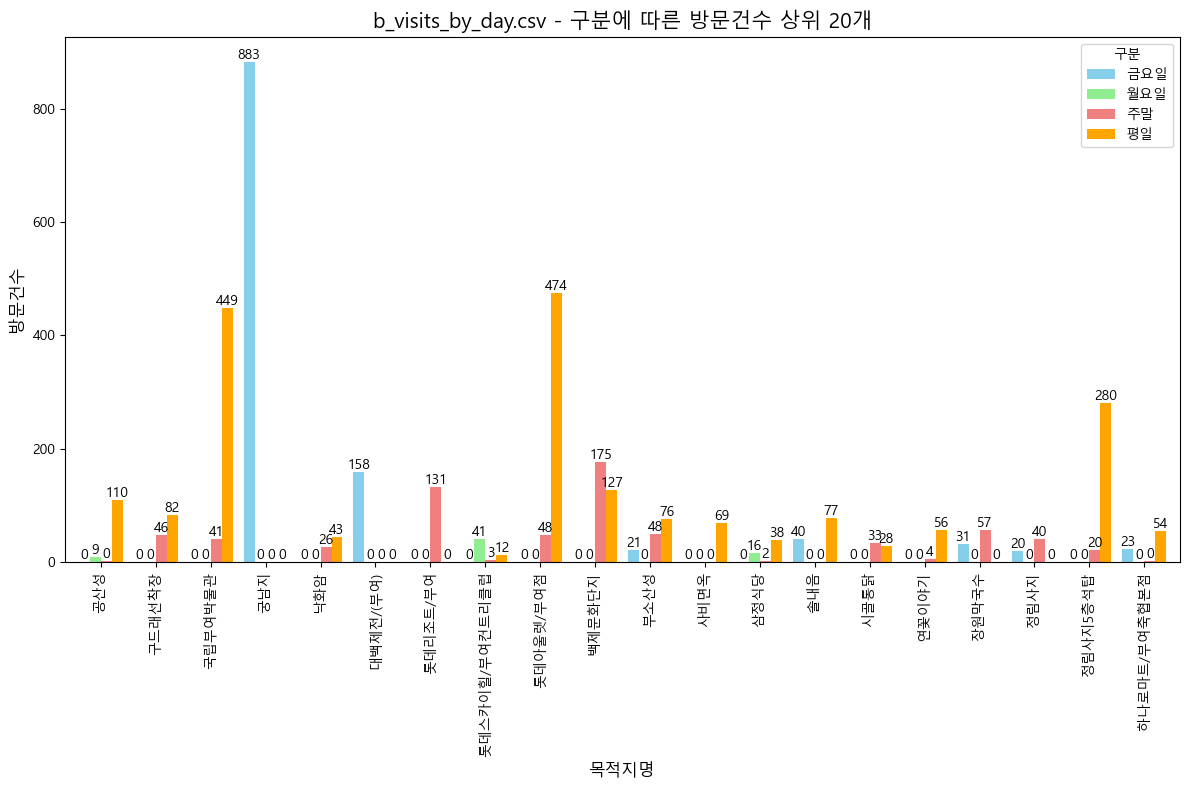

<Figure size 1200x800 with 0 Axes>

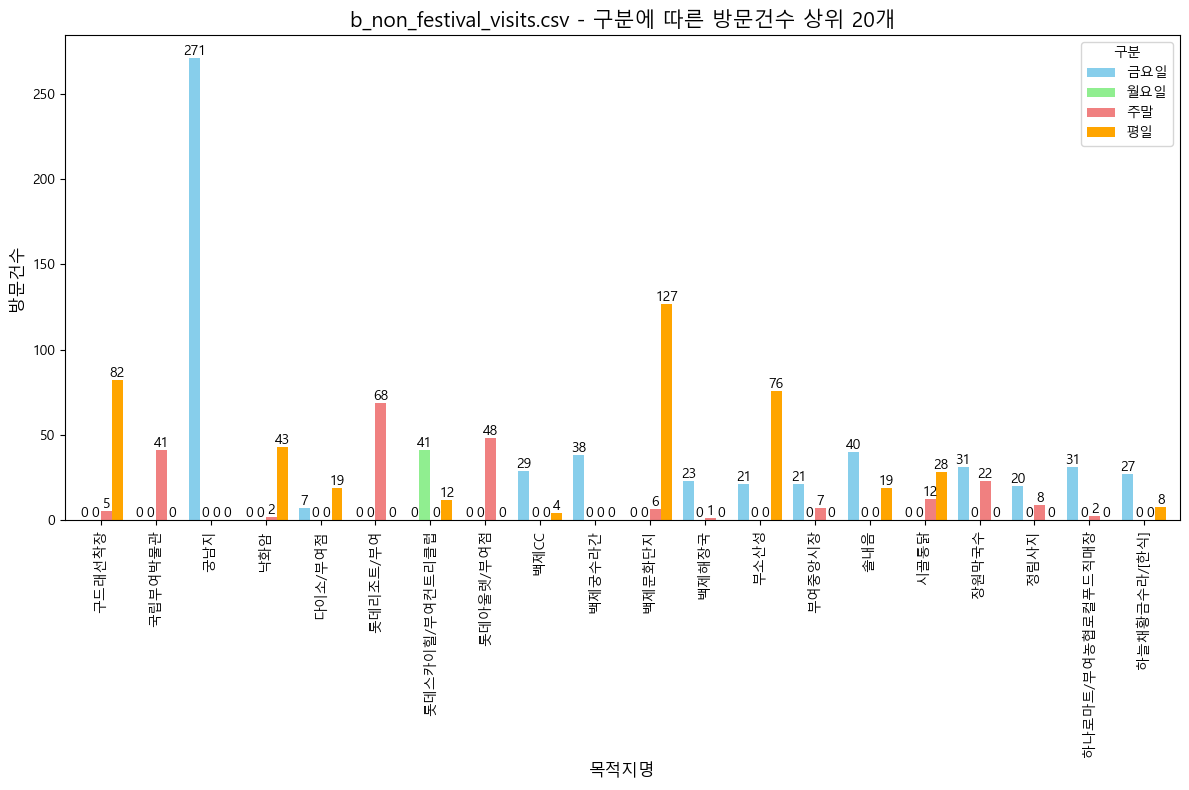

<Figure size 1200x800 with 0 Axes>

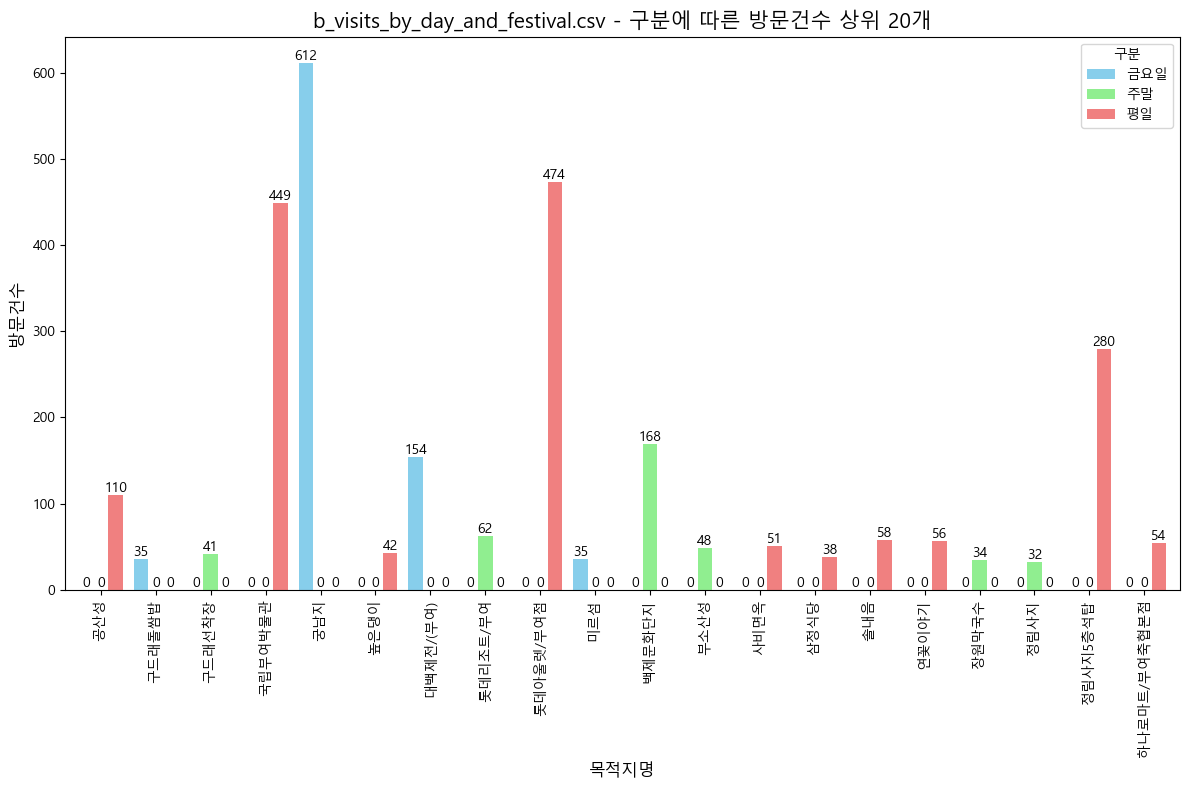

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

csv_files = ['b_visits_by_day.csv', 'b_non_festival_visits.csv', 'b_visits_by_day_and_festival.csv']

# 각 CSV 파일에 대해 작업 수행
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    
    # '목적지명_통합'이 없으면 '목적지명'으로 대체
    destination_col = '목적지명_통합' if '목적지명_통합' in df.columns else '목적지명'
    
    # 방문건수에 따른 내림차순 정렬 (목적지명별로 하나씩만 추출)
    df_grouped = df.groupby(destination_col, as_index=False)['방문건수'].sum().sort_values(by='방문건수', ascending=False)
    
    # 상위 20개의 목적지명 선택
    top_20_destinations = df_grouped[destination_col].head(20).unique()
    
    # 상위 20개의 목적지명을 포함하는 데이터만 필터링
    top_20 = df[df[destination_col].isin(top_20_destinations)]
    
    # '구분'에 따른 방문건수를 묶어서 시각화
    plt.figure(figsize=(12, 8))
    
    # 구분에 따라 데이터를 그룹화
    grouped = top_20.groupby(['구분', destination_col])['방문건수'].sum().unstack('구분')

    # 막대그래프 그리기
    ax = grouped.plot(kind='bar', figsize=(12, 8), width=0.8, color=['skyblue', 'lightgreen', 'lightcoral', 'orange'])
    
    # 그래프 제목과 축 레이블
    plt.title(f"{csv_file} - 구분에 따른 방문건수 상위 20개", fontsize=15)
    plt.xlabel('목적지명', fontsize=12)
    plt.ylabel('방문건수', fontsize=12)
    
    # x축 라벨을 가독성 좋게 90도 회전
    plt.xticks(rotation=90)
    
    # 값 레이블 추가
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom', fontsize=10, color='black')

    # 레이아웃을 깔끔하게 조정
    plt.tight_layout()
    
    # 그래프 표시
    plt.show()
